In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /kaggle/input/d/msambare/fer2013


In [24]:
import os
import cv2 as cv
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pathlib
import seaborn as sns

In [4]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1734698347.106727      13 service.cc:145] XLA service 0x5c856748d260 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734698347.106781      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1734698347.106785      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1734698347.106788      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1734698347.106809      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1734698347.106813      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1734698347.106815      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1734698347.106818      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1734698347.106821      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [44]:
TRAIN_PATH = pathlib.Path('/kaggle/input/fer2013/FER2013-down_sampling_augmented')
TEST_PATH = pathlib.Path('/kaggle/input/d/msambare/fer2013/test')
LABEL_NAMES = ["angry", "fear", "happy", "neutral", "sad", "surprise"]
NUM_CLASSES = len(LABEL_NAMES)
BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync
IMG_SIZE = (224,224)
AUTOTUNE = tf.data.AUTOTUNE
IMG_SHAPE = IMG_SIZE + (3,)
VALIDATION_SPLIT = 0.2
SEED = 42
SHUFFLE = True

LABEL_INDICES = [i for i in range(0, NUM_CLASSES)]

model_params = {
    'train_path': TRAIN_PATH,
    'test_path': TEST_PATH,
    'label_names': LABEL_NAMES,
    'num_classes': NUM_CLASSES,
    'batch_size': BATCH_SIZE,
    'img_size': IMG_SIZE,
    'img_shape': IMG_SHAPE,
    'validation_split': VALIDATION_SPLIT,
    'seed': SEED,
    'shuffle': SHUFFLE
}

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=VALIDATION_SPLIT,
    subset='training',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_names=LABEL_NAMES
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_names=LABEL_NAMES
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    image_size=IMG_SIZE,
    class_names=LABEL_NAMES
)

train_ds = train_ds.shuffle(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

Found 72000 files belonging to 6 classes.
Using 57600 files for training.
Found 72000 files belonging to 6 classes.
Using 14400 files for validation.
Found 7067 files belonging to 6 classes.


In [ ]:
preprocess_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomTranslation(0,0.1)
])

def augment(image, label):
    image = preprocess_layer(image)
    return image, label

train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE).shuffle(BATCH_SIZE).prefetch(AUTOTUNE)

In [26]:
base_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=base_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=3,verbose=1,restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,verbose=1,min_delta=0.000001)

with tpu_strategy.scope():
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    preprocess_input = tf.keras.applications.resnet.preprocess_input
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=IMG_SHAPE
    )
    global_average = tf.keras.layers.GlobalAveragePooling2D()
    dense_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    base_model.trainable = False

    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = global_average(x)
    outputs = dense_layer(x)
    model = tf.keras.Model(inputs, outputs)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    initial_epochs = 20
    history = model.fit(train_ds,
                        epochs=initial_epochs,
                        validation_data=val_ds,
                       callbacks=[early_stopping, reduce_lr])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 6)         │     12,294 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20


2024-12-20 13:26:35.738240: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1734701217.628412     797 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(3e6643063bdb1625:0:0), session_name()


  3/450 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.1285 - loss: 2.2752   

I0000 00:00:1734701222.178842     797 tpu_compile_op_common.cc:245] Compilation of 3e6643063bdb1625:0:0 with session name  took 4.550346587s and succeeded
I0000 00:00:1734701222.192135     797 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(3e6643063bdb1625:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16951832371730005490", property.function_library_fingerprint = 10435789154804328517, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16,224,224,3,;16,;16,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734701222.192173     797 tpu_compilation_cache_interface.cc:541] After adding entry for 

450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2563 - loss: 1.8325

I0000 00:00:1734701248.200933     837 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(853c4e2e7be0fd04:0:0), session_name()
I0000 00:00:1734701252.960840     837 tpu_compile_op_common.cc:245] Compilation of 853c4e2e7be0fd04:0:0 with session name  took 4.759833373s and succeeded
I0000 00:00:1734701252.980917     837 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(853c4e2e7be0fd04:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15337897029123535321", property.function_library_fingerprint = 16704477338190396473, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16,224,224,3,;16,;", property.guaranteed_constants_size = 0, embe

450/450 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step - accuracy: 0.2564 - loss: 1.8321 - val_accuracy: 0.4122 - val_loss: 1.4958
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 51s 64ms/step - accuracy: 0.4232 - loss: 1.4634 - val_accuracy: 0.4433 - val_loss: 1.4067
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.4427 - loss: 1.4124 - val_accuracy: 0.4839 - val_loss: 1.3388
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.4816 - loss: 1.3516 - val_accuracy: 0.4856 - val_loss: 1.3107
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 50s 63ms/step - accuracy: 0.4869 - loss: 1.3196 - val_accuracy: 0.4839 - val_loss: 1.3249
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - accuracy: 0.5094 - loss: 1.2742 - val_accuracy: 0.5083 - val_loss: 1.2752
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 51s 63ms/step - accuracy: 0.5097 - loss: 1.2655 - val_accuracy: 0.5083 - val_loss: 1.2760
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - accuracy: 0.5134 - loss: 1.2532 - val_accurac

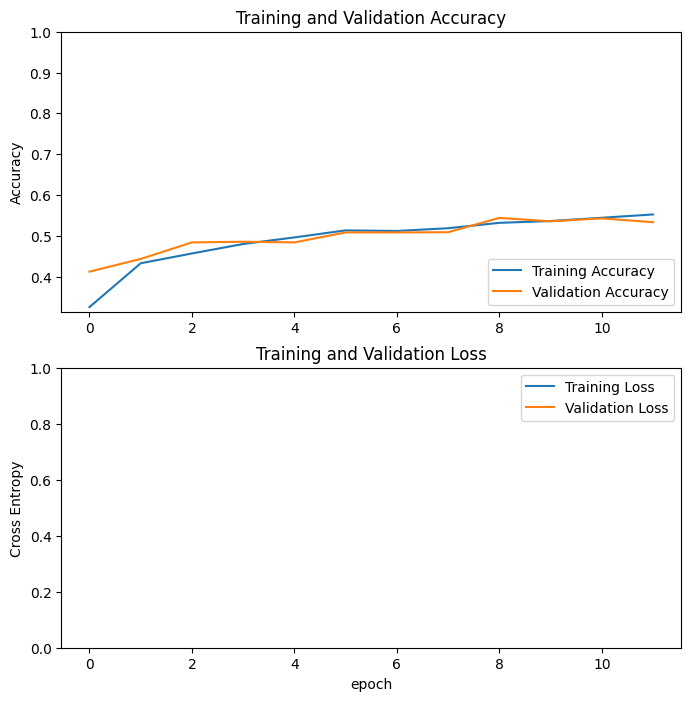

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
base_model.trainable = True
base_learning_rate = 0.00001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=base_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              verbose=1,
                              min_delta=0.0000001)

with tpu_strategy.scope():
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    fine_tune_epochs = 20
    total_epochs =  initial_epochs + fine_tune_epochs

    history_fine = model.fit(train_ds,
                             epochs=total_epochs,
                             initial_epoch=len(history.epoch),
                             validation_data=val_ds,
                            callbacks=[early_stopping, reduce_lr])

Epoch 13/30


2024-12-20 13:37:50.734457: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1734701894.834370     816 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(49581ed8b5272a3e:0:0), session_name()
I0000 00:00:1734701918.595985     816 tpu_compile_op_common.cc:245] Compilation of 49581ed8b5272a3e:0:0 with session name  took 23.761550543s and succeeded
I0000 00:00:1734701918.677387     816 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(49581ed8b5272a3e:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_7570094356730480413", property.function_library_fingerprint = 5482707498496928790, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z =

450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.4288 - loss: 1.4577

2024-12-20 13:39:33.210593: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.


450/450 ━━━━━━━━━━━━━━━━━━━━ 124s 139ms/step - accuracy: 0.4289 - loss: 1.4574 - val_accuracy: 0.4972 - val_loss: 1.2506
Epoch 14/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 82s 134ms/step - accuracy: 0.6009 - loss: 1.0463 - val_accuracy: 0.6411 - val_loss: 0.9609
Epoch 15/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 82s 134ms/step - accuracy: 0.6706 - loss: 0.8999 - val_accuracy: 0.6767 - val_loss: 0.8666
Epoch 16/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 82s 133ms/step - accuracy: 0.7356 - loss: 0.7438 - val_accuracy: 0.7044 - val_loss: 0.7737
Epoch 17/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 82s 134ms/step - accuracy: 0.7893 - loss: 0.6123 - val_accuracy: 0.7539 - val_loss: 0.6705
Epoch 18/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 81s 131ms/step - accuracy: 0.8317 - loss: 0.5026 - val_accuracy: 0.7933 - val_loss: 0.6036
Epoch 19/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 80s 130ms/step - accuracy: 0.8757 - loss: 0.4008 - val_accuracy: 0.7883 - val_loss: 0.5994
Epoch 20/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 81s 131ms/step - accuracy: 0.8976 - loss: 0.31

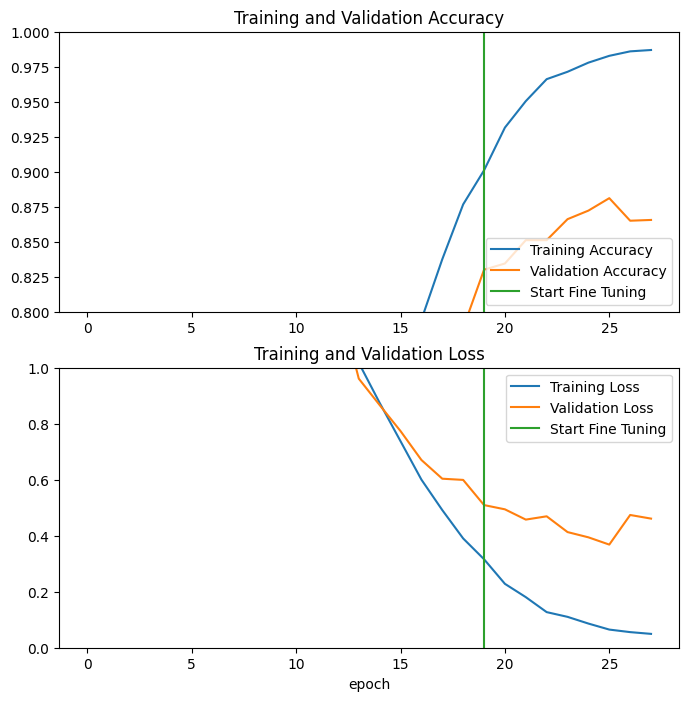

In [29]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
images_ = []
labels_ = []

for images, labels in test_ds:
    for img in images:
        images_.append(img.numpy())
    for label in labels:
        labels_.append(label.numpy())

images_np = np.array(images_)

pred = model.predict(images_np[:7000])

pred_res = []
for p in pred:
    pred_res.append(np.argmax(p))

print(accuracy_score(labels_[:7000], pred_res))

2024-12-20 14:00:17.280437: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1_1/dense_3_1/Add/ReadVariableOp.
I0000 00:00:1734703217.880911     788 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(2bfb3a5efeebb6f5:0:0), session_name()


  3/219 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step

I0000 00:00:1734703225.042833     788 tpu_compile_op_common.cc:245] Compilation of 2bfb3a5efeebb6f5:0:0 with session name  took 7.161878905s and succeeded
I0000 00:00:1734703225.054643     788 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(2bfb3a5efeebb6f5:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_16876814886452406706", property.function_library_fingerprint = 10404372250450978715, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734703225.054675     788 tpu_compilation_cache_interface.cc:541] After adding entry for key 2bfb3a5efe

218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

I0000 00:00:1734703242.167418     826 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(3c7dd1d0db249b80:0:0), session_name()


219/219 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step


I0000 00:00:1734703250.591602     826 tpu_compile_op_common.cc:245] Compilation of 3c7dd1d0db249b80:0:0 with session name  took 8.424140436s and succeeded
I0000 00:00:1734703250.603197     826 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(3c7dd1d0db249b80:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_13474141095356494924", property.function_library_fingerprint = 7930820605786287649, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,224,224,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734703250.603226     826 tpu_compilation_cache_interface.cc:541] After adding entry for ke

0.645


In [31]:
report = classification_report(labels_[:7000], pred_res)
print(report)

              precision    recall  f1-score   support

           0       0.57      0.59      0.58       949
           1       0.51      0.48      0.49      1015
           2       0.86      0.82      0.84      1756
           3       0.58      0.61      0.59      1220
           4       0.52      0.47      0.49      1238
           5       0.71      0.85      0.78       822

    accuracy                           0.65      7000
   macro avg       0.63      0.64      0.63      7000
weighted avg       0.64      0.65      0.64      7000



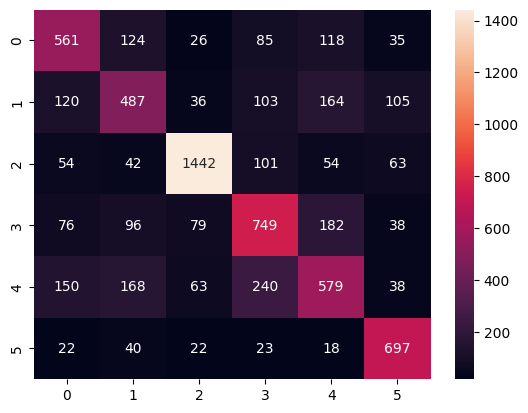

In [38]:
cm = confusion_matrix(labels_[:7000], pred_res)
sns.heatmap(cm, annot=True, fmt='d')
plt.savefig('confusion_matrix.png')
plt.show()

In [41]:
metrics = {
    'accuracy': accuracy_score(labels_[:7000], pred_res),
    'precision': precision_score(labels_[:7000], pred_res, average='macro'),
    'recall': recall_score(labels_[:7000], pred_res, average='macro'),
    'f1': f1_score(labels_[:7000], pred_res, average='macro'),
    'auc_score': roc_auc_score(labels_[:7000], pred, multi_class='ovr', average='macro')
}

print(f"Accuracy: {metrics['accuracy']}\nPrecision: {metrics['precision']}\nRecall: {metrics['recall']}\nF1 Score: {metrics['f1']}\nAUC Score: {metrics['auc_score']}")

Accuracy: 0.645
Precision: 0.6255375159728361
Recall: 0.6369486942280652
F1 Score: 0.6297670179837379
AUC Score: 0.884035467498153


In [40]:
!pip install dagshub --quiet
!pip install mlflow --quiet


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [42]:
import mlflow
import dagshub
dagshub.init(repo_owner='IdjiotSandwiches', repo_name='face-emotion-recognition', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

/usr/local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=fd986320-4b8b-468b-834b-d4bafcecd322&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=60eabc5abc569d38d57ed1130d26e05d0c09316131ede03bdf1a8b2e9c923621




Accessing as IdjiotSandwiches

Initialized MLflow to track repo "IdjiotSandwiches/face-emotion-recognition"

Repository IdjiotSandwiches/face-emotion-recognition initialized!

In [49]:
for images, labels in test_ds.take(1):
    input_example = images[0].numpy()
    break 

In [53]:
model = tf.keras.models.clone_model(model)
model.save('ResNet50.h5')

In [50]:
mlflow.set_experiment("ResNet50 Transfer Learning")
mlflow.set_tracking_uri("https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow")

with mlflow.start_run(run_name=f'ResNet50'):
    mlflow.log_artifact('confusion_matrix.png')
    mlflow.log_params(model_params)
    mlflow.tensorflow.log_model(
        model,
        artifact_path='ResNet50_TransferLearning',
        input_example=input_example
    )

2024/12/20 14:07:45 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: ValueError('input tensor Tensor("data:0", dtype=float32) to TPUStrategy.run() has unknown rank, which is not allowed'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.
2024/12/20 14:07:45 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


🏃 View run ResNet50 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/23/runs/3b4a5625914c4aeab514d9f45dccb458
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/23


ValueError: Device /job:localhost/replica:0/task:0/device:CPU:0 is not found